In [2]:
import pandas as pd
import datetime as dt
import numpy as np
from pandas import Timestamp


In [ ]:
excel_file = pd.ExcelFile("queues_2023_clean_data.xlsx")
interconnection_data = excel_file.parse("data")


In [4]:
interconnection_data.drop(["q_year","prop_year"], axis=1, inplace=True)

In [5]:

date_columns = ["q_date","ia_date","wd_date","on_date","prop_date"]
for col in date_columns:
    interconnection_data[col] = pd.to_datetime(interconnection_data[col],errors = "coerce")


In [ ]:
def categorical_change(data,column):
    """Changes a column into categorical variables"""
    i=0
    seen = {}
    categorical = []
    for _, row in data.iterrows():
        item = row[column]
        if item not in seen:
            seen[item] = i
            i+=1
        categorical.append(seen[item])
    data[column] = categorical

def select_iso(data,*isos):
    "Extracts data from select isos"
    result = []
    for iso in isos:
        result.append(data[data["entity"] == iso])
    result = tuple(result)
    return result

def sort_iso(*isos):
    """Sort ISO by the date they entred the queue"""
    result = []
    for iso in isos:
        sorted_iso = iso.sort_values(by = "q_date",ascending = True)
        result.append(sorted_iso)
    result = tuple(result)
    return result

def calculate_difference(df, unit='years'):
    """For projects that have been deployed, calculates
    the time difference between the start date and end date"""
    time_difference = []
    for index, row in df.iterrows():
        if unit == "years":
            time_difference.append((row["on_date"] - row["q_date"])/365)
        elif unit == "months":
            time_difference.append((row["on_date"] - row["q_date"])/12)
        elif unit == "days":
            time_difference.append(row["on_date"] - row["q_date"])
    return time_difference


def queue_length(iso,initial_queue=0):
    """Calculates the current length of the queue at a current point in time based
    solely on the number of projects added plus an initial amount"""
    queues = np.zeros(iso.shape[0])
    queues[0] = initial_queue
    completion_dates = list(iso["on_date"])
    withdraw_dates = list(iso[iso["wd_date"].notna()]["wd_date"])
    for i, (_,row) in enumerate(iso.iterrows()): #iterating over every project
        current_time = row["q_date"]
        if not withdraw_dates:
            first_withdraw_date = Timestamp("2099-12-12")
        else:
            first_withdraw_date = min(withdraw_dates)
        first_completion_date = min(completion_dates)
        if i>0:
            queues[i] = queues[i -1]
        queues[i] +=1
        if current_time > first_completion_date:
            queues[i]-=1
            completion_dates.remove(first_completion_date)
        elif current_time > first_withdraw_date:
            queues[i] -=1
            withdraw_dates.remove(first_withdraw_date)
    return queues

categorical_columns = ['']
caiso, ercot, pjm, iso_ne = select_iso(interconnection_data,"CAISO","ERCOT","PJM","ISO-NE")
sorted_caiso, sorted_ercot, sorted_pjm, sorted_iso_ne = sort_iso(caiso, ercot, pjm, iso_ne)


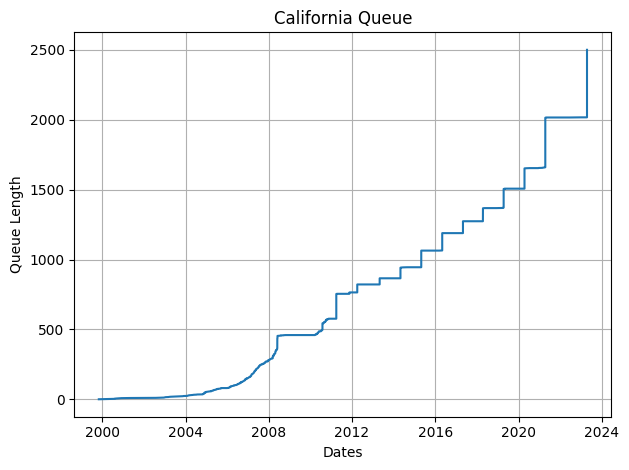

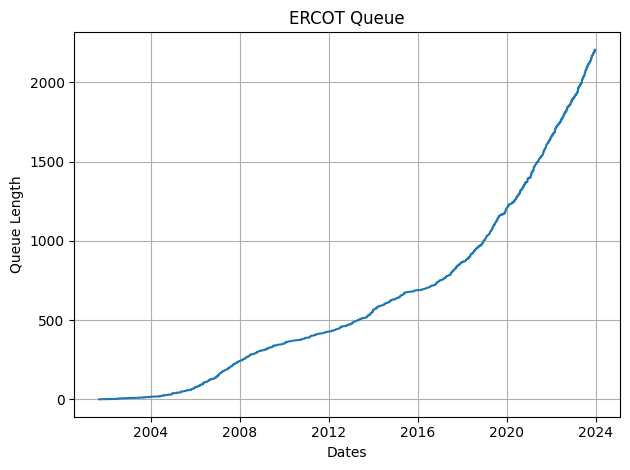

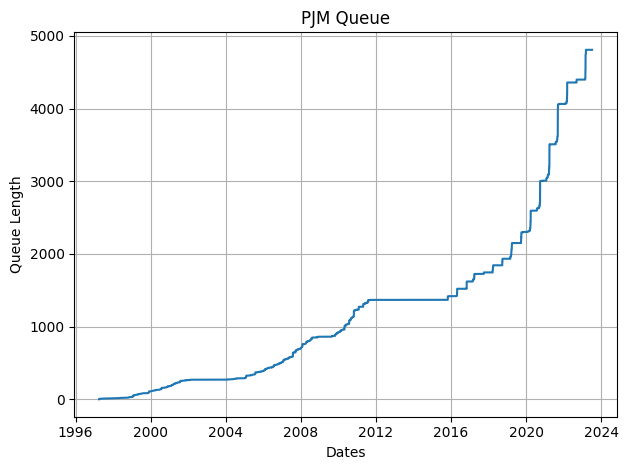

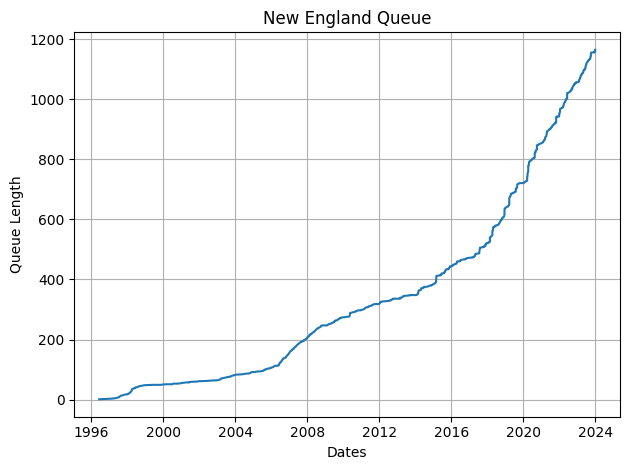

In [8]:
import matplotlib.pyplot as plt
iso_list = {"California":sorted_caiso,"ERCOT":sorted_ercot,"PJM":sorted_pjm,"New England":sorted_iso_ne }
for name, iso in iso_list.items():
    queue = queue_length(iso)
    iso["queue"] = queue
    dates = iso["q_date"]
    plt.plot(dates,queue)
    plt.xlabel("Dates")
    plt.ylabel("Queue Length")
    plt.title(f"{name} Queue")
    plt.grid()
    plt.tight_layout()
    plt.show()

### Linear Regression for Deployed  Power Plants

In [61]:
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LinearRegression
from sklearn.metrics import mean_squared_error, r2_score

def linear_regression(iso):

    iso = iso[iso["on_date"].notna()] # only select projects that have been deployed
    iso["time_difference"] = calculate_difference(iso,"years")
    categorical_columns = ["type1","type2","type3"]
    for col in categorical_columns:
        categorical_change(iso,col)
    X = np.nan_to_num(iso[["type1","type2","type3","mw1","mw2","mw3","queue"]].to_numpy())
    y = iso["time_difference"].to_numpy()

    X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=42)

    model = LinearRegression()
    model.fit(X_train, y_train)

    y_pred = model.predict(X_test)

    mse = mean_squared_error(y_test, y_pred)
    r2 = r2_score(y_test, y_pred)

    print(f"R^2 Score: {r2:.2f}")

for i in [sorted_caiso,sorted_ercot,sorted_iso_ne]:
    linear_regression(i)


R^2 Score: 0.26
R^2 Score: 0.12
R^2 Score: -0.10


C:\Users\claud\AppData\Local\Temp\ipykernel_9404\1358615682.py:8: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  iso["time_difference"] = calculate_difference(iso,"years")
C:\Users\claud\AppData\Local\Temp\ipykernel_9404\2335282900.py:12: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data[column] = categorical
C:\Users\claud\AppData\Local\Temp\ipykernel_9404\2335282900.py:12: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = 

In [57]:
print(sorted_pjm)
sorted_pjm = sorted_pjm[sorted_pjm["on_date"].notna()] # only select projects that have been deployed
# sorted_pjm["time_difference"] = calculate_difference(sorted_pjm,"years")
# categorical_columns = ["type1","type2","type3"]
# for col in categorical_columns:
#     categorical_change(iso,col)

print(sorted_pjm)

Empty DataFrame
Columns: [q_id, q_status, q_date, ia_date, wd_date, on_date, entity, project_name, developer, utility, county_1, county_2, county_3, state, region, service, poi_name, prop_date, IA_status_raw, IA_status_clean, type_clean, type1, type2, type3, mw1, mw2, mw3, queue, time_difference]
Index: []

[0 rows x 29 columns]
Empty DataFrame
Columns: [q_id, q_status, q_date, ia_date, wd_date, on_date, entity, project_name, developer, utility, county_1, county_2, county_3, state, region, service, poi_name, prop_date, IA_status_raw, IA_status_clean, type_clean, type1, type2, type3, mw1, mw2, mw3, queue, time_difference]
Index: []

[0 rows x 29 columns]
